In [ ]:
export HOME=/data/vision/polina/users/clintonw
export PATH=$PATH:/data/vision/polina/shared_software/anaconda3/bin
export PROJ=/data/vision/polina/projects/wmh/clintonw
source activate clinton
cd "$HOME/code/vision_final/scripts"

In [1]:
import shutil
import importlib
import itertools
import glob, os
from os.path import *

import scipy.stats as stats
import scipy.optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count() - 2

import copy
import niftiutils.io as io

In [2]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import util
import analysis as ana

import networks.base as nets
import networks.dense2 as dense2
import datasets.common as datasets
import datasets.mnist as mnist
import datasets.cifar as cifar
import scripts.train_classifier as main
nn = torch.nn

In [3]:
import warnings
warnings.filterwarnings("ignore")

#np.set_printoptions(suppress=True)

In [14]:
importlib.reload(util);

In [4]:
util.clean_df()

### experiments

In [7]:
arg_list = util.get_ordered_experiments()

In [ ]:
print(util.args_to_sh(arg_list[0], n_gpus=2))

In [299]:
print(util.args_to_sh(arg_list[8], slurm=False, exc_gpu=2))

CUDA_VISIBLE_DEVICES=1,2,3,4,5,6,7 nohup python train_classifier.py --noise_p 0.5 --mc_drop 0.3 --arch dense > py0.out 2> py0.err < /dev/null &


In [ ]:
CUDA_VISIBLE_DEVICES=1,2,3 nohup python train_classifier.py --noise_p 0.4 --arch all-conv --u_arch cat > py7.out 2> py7.err < /dev/null &

In [ ]:
python train_classifier.py --epochs 1 --mc_drop 0.3

In [10]:
args = main.get_args(arg_list[0])

In [183]:
from skimage.transform import rescale

In [184]:
labels[0]

tensor([ 9,  6, 15], device='cuda:0')

In [188]:
ixs = np.array([np.min(np.where(labels[:,0] == i)[0]) for i in range(10)])
I = imgs[ixs,0]
I = np.concatenate([I[sl] for sl in range(I.shape[0])], 1)
I = np.concatenate([I[:,:I.shape[1]//2], I[:,I.shape[1]//2:]], 0)
Ibig = rescale(I,3)
plt.figure(figsize=(20,20))
plt.imsave('sample.png', Ibig, cmap='gray')

### I/O

In [ ]:
[os.remove(fn) for fn in glob.glob('logs/events*')]

In [ ]:
[os.removedirs(fn) for fn in glob.glob('logs/*') if len(os.listdir(fn))==0]

In [ ]:
glob.glob('logs/*')

In [ ]:
[os.remove(fn) for fn in glob.glob('data/mnist/*.npy')]

In [ ]:
glob.glob('data/fmnist/*.npy')

In [ ]:
[os.remove(fn) for fn in glob.glob('scripts/*.err')]

In [ ]:
for fn in glob.glob('scripts/*.err'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F)>2 and 'error' in F[-1].lower():
        print(fn, F[-10:])

In [ ]:
for fn in glob.glob('scripts/*.out'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F) < 18:
        print(fn, F[-10:])

In [7]:
with open('scripts/srun2.err', 'r') as f:
    F=f.readlines()
F[-10:]

['srun: job 478512 queued and waiting for resources\n']

## PPT 

In [6]:
import time
time.time()

1544155523.681592

In [7]:
import seaborn as sns
def load_csv(binom=False):
    csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
    df = pd.read_csv(csv_path, index_col=0)
    df = df[(df['epochs'] > 5) & (df['acc'] > 0) & (df['dataset'] == 'fmnist') & (df['nU'] == 10) & (
            ~df.index.str.contains('frequency'))]
    if not binom:
        df = df[~df['model_type'].str.contains('_bin')]
    return df

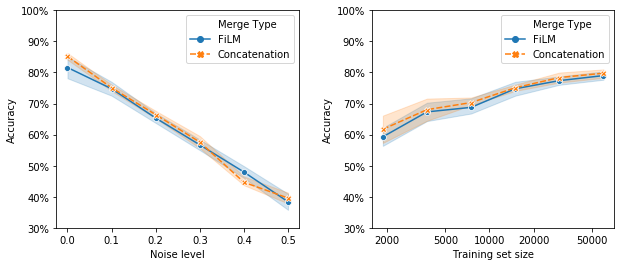

In [9]:
df = load_csv()
df.loc[df['u_arch'] == 'cat', 'u_arch'] = 'Concatenation'
df.loc[df['u_arch'] == 'film', 'u_arch'] = 'FiLM'

## film/cat
order = ['FiLM', 'Concatenation']
kwargs = {"y":'acc', "style":'Merge Type', "hue":'Merge Type', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['arch'] == 'all-conv') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['arch'] == 'all-conv') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

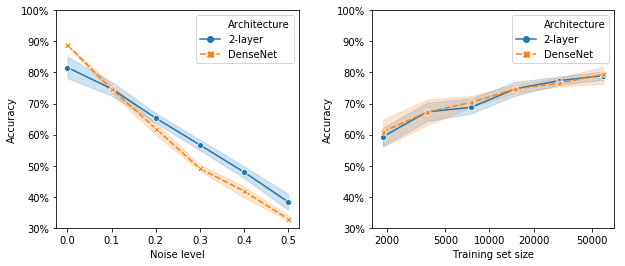

In [16]:
df = load_csv()
df.loc[df['arch'] == 'all-conv', 'arch'] = '2-layer'
df.loc[df['arch'] == 'dense', 'arch'] = 'DenseNet'
## dense/simple
order = ['2-layer', 'DenseNet']
kwargs = {"y":'acc', "style":'Architecture', "hue":'Architecture', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

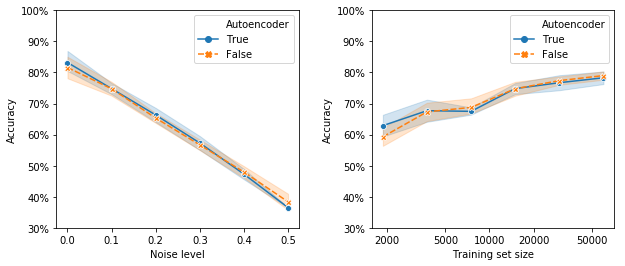

In [23]:
df = load_csv()
df['Autoencoder'] = df['arch'].str.contains('ae')
df.loc[df['arch'] == 'ae', 'arch'] = 'all-conv'
df.loc[df['arch'] == 'dense-ae', 'arch'] = 'dense'

## ae reg
order = [True, False]
kwargs = {"y":'acc', "style":'Autoencoder', "hue":'Autoencoder', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['mc_drop'] == 0) & (df['arch'] == 'all-conv')]
#& ((df['timestamp'] > 1544151000) | (~df['Autoencoder']))

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0) & (
        df['arch'] == 'all-conv')]

df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

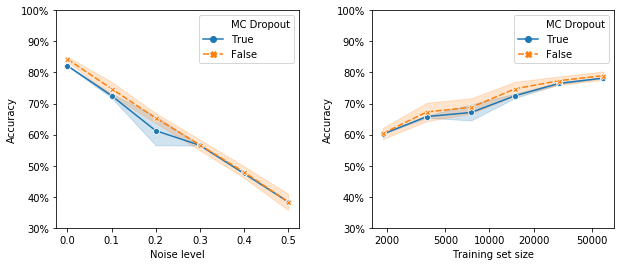

In [53]:
df = load_csv()
df['mc_drop'] = df['mc_drop'] > 0

## ae reg
order = [True, False]
kwargs = {"y":'acc', "style":'MC Dropout', "hue":'MC Dropout', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['arch'] == 'all-conv')]
df_sub.rename(columns={'mc_drop':'MC Dropout'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['arch'] == 'all-conv') & (df['arch'] == 'all-conv')]
df_sub.rename(columns={'mc_drop':'MC Dropout'}, inplace=True)

df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

### KL div

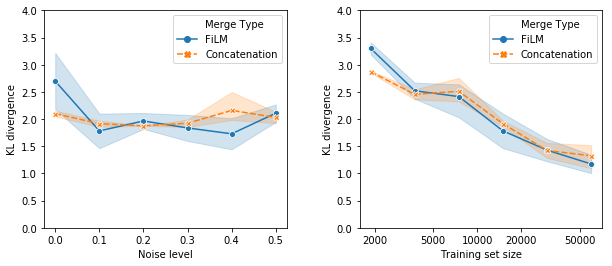

In [64]:
df = load_csv()
df.loc[df['u_arch'] == 'cat', 'u_arch'] = 'Concatenation'
df.loc[df['u_arch'] == 'film', 'u_arch'] = 'FiLM'

## film/cat
order = ['FiLM', 'Concatenation']
kwargs = {"y":'true_KL', "style":'Merge Type', "hue":'Merge Type', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['arch'] == 'all-conv') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')
plt.ylim(0,4);

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['arch'] == 'all-conv') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
plt.ylim(0,4);
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

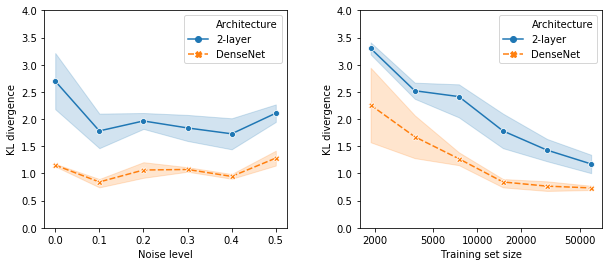

In [63]:
df = load_csv()
df.loc[df['arch'] == 'all-conv', 'arch'] = '2-layer'
df.loc[df['arch'] == 'dense', 'arch'] = 'DenseNet'
## dense/simple
order = ['2-layer', 'DenseNet']
kwargs = {"y":'true_KL', "style":'Architecture', "hue":'Architecture', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')
plt.ylim(0,4);

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae'))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);
plt.ylim(0,4);

plt.subplots_adjust(wspace = 0.3)

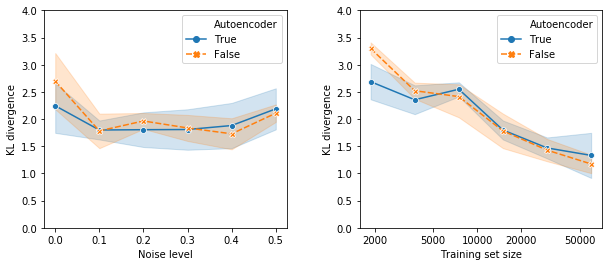

In [22]:
df = load_csv()
df['Autoencoder'] = df['arch'].str.contains('ae')
df.loc[df['arch'] == 'ae', 'arch'] = 'all-conv'
df.loc[df['arch'] == 'dense-ae', 'arch'] = 'dense'

## ae reg
order = [True, False]
kwargs = {"y":'true_KL', "style":'Autoencoder', "hue":'Autoencoder', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['mc_drop'] == 0) & (df['arch'] == 'all-conv')]

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')
plt.ylim(0,4);

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0) & (df['arch'] == 'all-conv')]

df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
plt.ylim(0,4);
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

In [ ]:
df = load_csv()
df['mc_drop'] = df['mc_drop'] > 0

## ae reg
order = [True, False]
kwargs = {"y":'true_KL', "style":'MC Dropout', "hue":'MC Dropout', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['arch'] == 'all-conv') & (df['arch'] == 'all-conv')]
df_sub.rename(columns={'mc_drop':'MC Dropout'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')
plt.ylim(0,4);

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['arch'] == 'all-conv')]
df_sub.rename(columns={'mc_drop':'MC Dropout'}, inplace=True)

df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
plt.ylim(0,4);
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

### dense hyperpar

In [ ]:
df = load_csv()
df.loc[df['arch'] == 'all-conv', 'arch'] = '2-layer'
df.loc[df['arch'] == 'dense', 'arch'] = 'DenseNet'
## dense/simple
order = ['2-layer', 'DenseNet']
kwargs = {"y":'acc', "style":'Architecture', "hue":'Architecture', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae')) & (
        (df['arch']=='2-layer') | (df.index.str.contains('_long')))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae')) & (
        (df['arch']=='2-layer') | (df.index.str.contains('_long')))]
df_sub.rename(columns={'arch':'Architecture'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

### binomial

In [ ]:
df = load_csv(True)
df.loc[df['u_arch'] == 'cat', 'u_arch'] = 'Concatenation'
df.loc[df['u_arch'] == 'film', 'u_arch'] = 'FiLM'

## film/cat
order = ['FiLM', 'Concatenation']
kwargs = {"y":'acc', "style":'Merge Type', "hue":'Merge Type', "hue_order":order,
          "style_order":order, "markers":True}#, "ci":None}

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['arch'] == 'all-conv') & (
        df['mc_drop'] == 0) & (~df['arch'].str.contains('ae')) & (df['model_type'].str.contains('bin'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)

sns.lineplot(x='noise_p', data=df_sub, **kwargs)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])

ax = plt.subplot(122)
df_sub = df[(df['noise_p'] == .1) & (df['arch'] == 'all-conv') & (df['mc_drop'] == 0) & (
        ~df['arch'].str.contains('ae')) & (df['model_type'].str.contains('bin'))]
df_sub.rename(columns={'u_arch':'Merge Type'}, inplace=True)
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', data=df_sub, **kwargs)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.3,1);
vals = ax.get_yticks()
ax.set_yticklabels(['%d%%' % (x*100) for x in vals])
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

plt.subplots_adjust(wspace = 0.3)

## df analysis

### noise level

In [5]:
import seaborn as sns
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)
df = df[(df['epochs'] > 5) & (df['acc'] > 0) & (df['dataset'] == 'fmnist') & (df['nU'] == 10)]

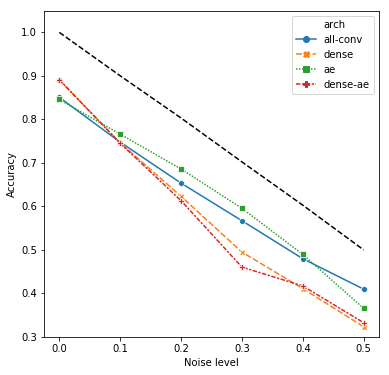

In [6]:
## Figure 2a - simple network outperforms densenet at higher noise levels, autoencoder regularization doesn't help
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
x = [0,.1,.2,.3,.4,.5]
y = [df.loc[df['noise_p'] == p, 'emp_est_acc'][0] for p in x]
plt.plot(x, y, 'k--')

sns.lineplot(x='noise_p', y='acc', data=df_sub, style='arch', hue='arch', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1.05);

In [ ]:
df_sub[(df_sub['u_arch'] == 'cat') & (df_sub['noise_p'] == .4)]

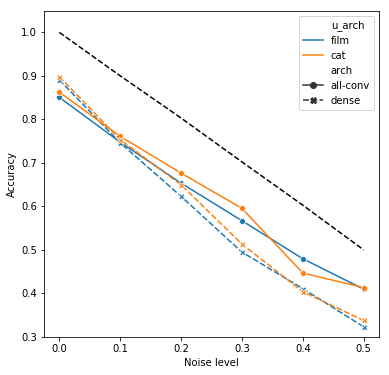

In [16]:
## Figure 2b
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (
        ~df['arch'].str.contains('ae')) & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
x = [0,.1,.2,.3,.4,.5]
y = [df.loc[df['noise_p'] == p, 'emp_est_acc'][0] for p in x]
plt.plot(x, y, 'k--')

sns.lineplot(x='noise_p', y='acc', data=df_sub, style='arch', hue='u_arch', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1.05);

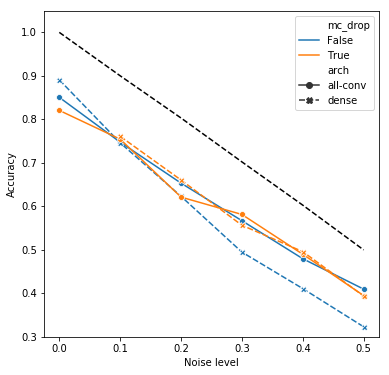

In [18]:
## Figure 2c - MC dropout
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (
        ~df['arch'].str.contains('ae')) & (df['u_arch'] == 'film')]
df_sub['mc_drop'] = df_sub['mc_drop'] > 0

plt.figure(figsize=(6,6))
x = [0,.1,.2,.3,.4,.5]
y = [df.loc[df['noise_p'] == p, 'emp_est_acc'][0] for p in x]
plt.plot(x, y, 'k--')

sns.lineplot(x='noise_p', y='acc', data=df_sub, style='arch', hue='mc_drop', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1.05);

### training set size

In [30]:
import seaborn as sns
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)
df = df[(df['epochs'] > 5) & (df['acc'] > 0) & (df['dataset'] == 'fmnist') & (df['nU'] == 10)]

df_sub.loc[df_sub['arch'] == 'dense-ae', ['N_train', 'acc']]

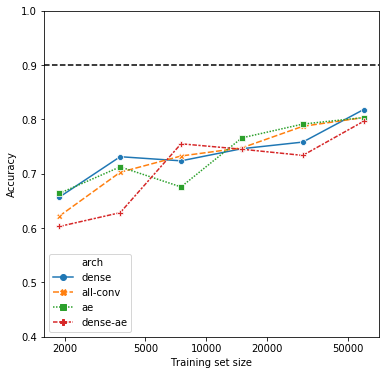

In [22]:
## Figure 3a - simple network outperforms densenet in smaller datasets, autoencoder regularization doesn't help
df_sub = df[(df['noise_p'] == 0.1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
plt.axhline(y=df_sub['true_est_acc'][0], linestyle='--', color='k')
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='acc', data=df_sub, style='arch', hue='arch', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

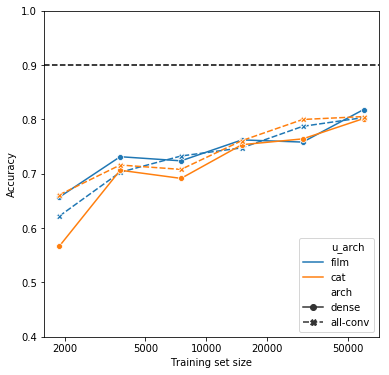

In [285]:
## Figure 3b - simple network outperforms densenet in smaller datasets, autoencoder regularization doesn't help
df_sub = df[(df['noise_p'] == 0.1) & (~df['arch'].str.contains('ae')) & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
plt.axhline(y=df_sub['true_est_acc'][0], linestyle='--', color='k')
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='acc', data=df_sub, style='arch', hue='u_arch', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

In [ ]:
df_sub[(df_sub['N_train'] == 7500) & (df_sub['mc_drop'] > 0)]

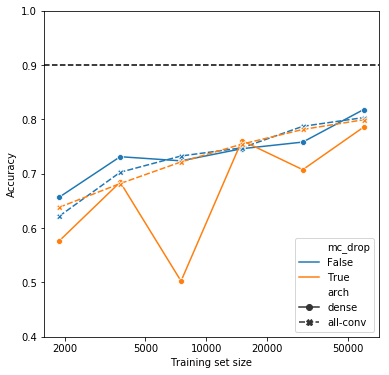

In [31]:
## Figure 3c - dropout
df_sub = df[(df['noise_p'] == 0.1) & (df['u_arch'] == 'film') & (~df['arch'].str.contains('ae'))]
df_sub['mc_drop'] = df_sub['mc_drop'] > 0

plt.figure(figsize=(6,6))
plt.axhline(y=df_sub['true_est_acc'][0], linestyle='--', color='k')
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='acc', data=df_sub, style='arch', hue='mc_drop', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

In [ ]:
df_sub[df_sub['acc'] < .5]

### Posterior

In [146]:
import seaborn as sns
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)
df = df[(df['epochs'] > 5) & (df['acc'] > 0) & (df['dataset'] == 'fmnist') & (df['nU'] == 10)]

In [ ]:
df_sub[df_sub['true_KL'] > 8]

Text(0,0.5,'KL divergence')

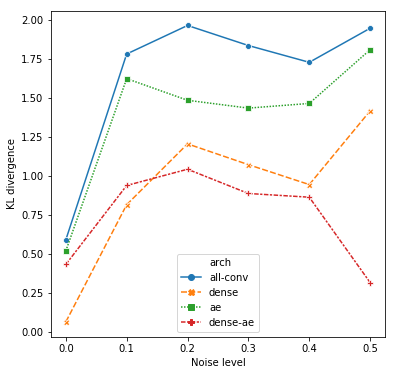

In [337]:
## Figure 4a
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
sns.lineplot(x='noise_p', y='true_KL', data=df_sub, style='arch', hue='arch', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')
#KL divergence penalizes predictions where the true distribution is 0, and does not penalize the absence of a prediction

In [ ]:
## Figure 4b
df_sub = df[(df['N_train'] == 15000) & (~df['arch'].str.contains('ae')) & (df['noise_p'] >= 0) & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
sns.lineplot(x='noise_p', y='true_KL', data=df_sub, style='arch', hue='u_arch', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')

In [ ]:
## Figure 5a - AE
df_sub = df[(df['noise_p'] == 0.1) & (df['mc_drop'] == 0)]

plt.figure(figsize=(6,6))
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='true_KL', data=df_sub, style='arch', hue='arch', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

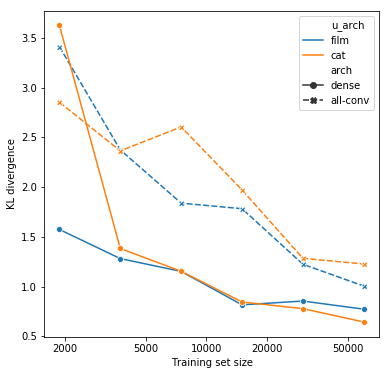

In [334]:
## Figure 5b
df_sub = df[(df['noise_p'] == 0.1) & (~df['arch'].str.contains('ae')) & (df['mc_drop'] == 0)]
x_filt = [60000//2**n for n in range(6)]
df_sub = df_sub[df_sub['N_train'].isin(x_filt)]

plt.figure(figsize=(6,6))
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='true_KL', data=df_sub, style='arch', hue='u_arch', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

Text(0,0.5,'KL divergence')

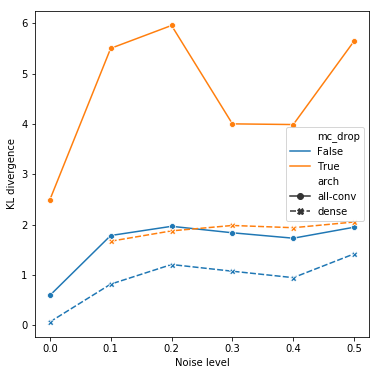

In [341]:
## Figure 4c
df_sub = df[(df['N_train'] == 15000) & (df['noise_p'] >= 0) & (df['u_arch'] == 'film') & (
        ~df['arch'].str.contains('ae'))]
df_sub['mc_drop'] = df_sub['mc_drop'] > 0

plt.figure(figsize=(6,6))
x = [0,.1,.2,.3,.4,.5]
y = [df.loc[df['noise_p'] == p, 'emp_est_acc'][0] for p in x]

sns.lineplot(x='noise_p', y='true_KL', data=df_sub, style='arch', hue='mc_drop', markers=True, ci=None)
plt.xlabel('Noise level')
plt.ylabel('KL divergence')

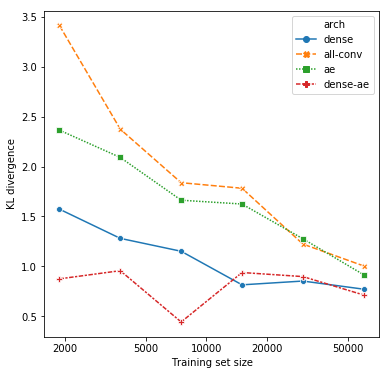

In [342]:
## Figure 3a - simple network outperforms densenet in smaller datasets, autoencoder regularization doesn't help
df_sub = df[(df['noise_p'] == 0.1) & (df['u_arch'] == 'film') & (df['mc_drop'] == 0)]
x_filt = [60000//2**n for n in range(6)]
df_sub = df_sub[df_sub['N_train'].isin(x_filt)]

plt.figure(figsize=(6,6))
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.lineplot(x='lnN_train', y='true_KL', data=df_sub, style='arch', hue='arch', markers=True, ci=None)
plt.xlabel('Training set size')
plt.ylabel('KL divergence')
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

## df QC

In [19]:
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)

In [99]:
x_filt = [60000//2**n for n in range(6)]

In [20]:
df = df[df['timestamp'] < 1544151000]

In [100]:
df = df[df['N_train'].isin(x_filt)]

In [ ]:
df.loc[(df['acc'] > 0) & (df['acc'] < .4), ['epochs', 'arch', 'u_arch', 'mc_drop', 'N_train', 'noise_p', 'timestamp', 'acc']]

In [ ]:
df.sort_values('timestamp', ascending=False)

In [91]:
df = df[df['N_train'] != 10000]

In [13]:
df = df.drop('N15Kfmnist_u10_y1+1d1_n40_all-conv_cat_0')

In [272]:
len(['model_type', 'n_params', 'N_train', 'dataset', 'nU', 'context_dist', 'Y_fn', 'noise_p', 'noise_lim', 'optim', 'arch'])

f = lambda x: 'cat' if 'cat' in x['model_type'] else 'film'
df['u_arch'] = df.apply(f, axis=1)

In [15]:
df = df[np.concatenate([df.columns[:12], df.columns[-1:], df.columns[12:-1]])]

In [156]:
df2 = df.sort_values('timestamp', ascending=False)[['acc', 'emp_est_acc', 'N_train', 'noise_p', 'epochs', 'timestamp']]

In [ ]:
df2[df2['N_train'] == 15000]

In [28]:
#df = df[df['epochs'] > 4]
#df = df[np.concatenate([df.columns[:6], df.columns[-1:], df.columns[6:-1]])]
df = df.drop('N7Kfmnist_u10_y1+1d1_n10_dense_filmdrop3_3')

In [21]:
df.to_csv(csv_path)

In [32]:
# undo removal from df
for fn in glob.glob('results/*Kfmnist*.hist'):
    hist = io.pickle_load(fn)
    if 'model_name' in hist:
        df.loc[hist['model_name']] = [hist[k] if k in hist else -1 for k in df.columns]

### recalc KL div

In [47]:
def softmax(x,ax):
    e_x = np.exp(x - np.max(x,ax, keepdims=True))
    return e_x / e_x.sum(ax, keepdims=True)

In [48]:
#name = "N15Kfmnist_u10_y1+1d1_n0_all-conv_film_0"
#row = df.loc[name]
for name, row in df.iterrows():
    if row['true_KL'] != 0:
        continue
    dims = (1,28,28)
    args = io.pickle_load("results/%s.hist" % name)

    ds = mnist.FMnistDS(train=False, args=args)
    bsz = args['bsz'] * torch.cuda.device_count()
    val_loader = datasets.get_loader(ds, bsz=bsz)
    assert args['arch'] == 'all-conv'
    i = args['Y_fn'].find('+')
    j = args['Y_fn'].find('d')
    A = int(args['Y_fn'][:i])
    B = int(args['Y_fn'][i+1:j])
    C = int(args['Y_fn'][j+1:])
    args['f'] = lambda z,u: (z*A+u*B)//C
    M = nets.FilmCNN(args, dims=dims).cuda()
    M = nn.DataParallel(M)
    M.train();
    for m in M.modules():
        if isinstance(m, nn.modules.BatchNorm2d):
            m.eval()

    preds = []
    for imgs, labels in val_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        target = labels[:,-1].long()
        context = torch.zeros(labels.size(0), args['nU'], dtype=torch.float).cuda()
        context.scatter_(1, labels[:,1].view(-1,1), 1.)
        preds.append(np.zeros((target.size(0), args['nY']), dtype=float))
        for _ in range(args['n_samples']):
            preds[-1] += M(imgs, context).detach().cpu().numpy()
            preds[-1] = softmax(preds[-1], 1)

    preds = np.concatenate(preds,0)
    hist = args
    hist['true_KL'], hist['emp_KL'], hist['true_JS'], hist['emp_JS'] = ana.get_stats(ds.synth_vars, args, preds)
    hist.pop('f');
    io.pickle_dump(hist, "results/%s.hist" % args['model_name'])

    df.loc[name] = [args[k] if k in hist else -1 for k in df.columns]

### different types of dropout sampling

In [ ]:
for name, row in df.iterrows():
    if row['mc_drop'] <= 0:
        continue
    dims = (1,28,28)
    args = io.pickle_load("results/%s.hist" % name)

    ds = mnist.FMnistDS(train=False, args=args)
    bsz = args['bsz'] * torch.cuda.device_count()
    val_loader = datasets.get_loader(ds, bsz=bsz)
    i = args['Y_fn'].find('+')
    j = args['Y_fn'].find('d')
    A = int(args['Y_fn'][:i])
    B = int(args['Y_fn'][i+1:j])
    C = int(args['Y_fn'][j+1:])
    args['f'] = lambda z,u: (z*A+u*B)//C
    if args['arch'] == 'all-conv':
        M = nets.FilmCNN(args, dims=dims).cuda()
    elif args['arch'] == 'dense':
        M = dense2.FilmDenseNet(args, dims=dims, dropout=args['mc_drop']).cuda()
    M = nn.DataParallel(M)
    M.train();
    for m in M.modules():
        if isinstance(m, nn.modules.BatchNorm2d):
            m.eval()

    preds = []
    acc = 0
    for imgs, labels in val_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        target = labels[:,-1].long()
        context = torch.zeros(labels.size(0), args['nU'], dtype=torch.float).cuda()
        context.scatter_(1, labels[:,1].view(-1,1), 1.)
        preds.append(np.zeros((target.size(0), args['nY']), dtype=float))
        for _ in range(args['n_samples']*2):
            tmp = torch.zeros(labels.size(0), args['nY'], dtype=torch.float).cuda()
            tmp.scatter_(1, torch.max(M(imgs, context), dim=1)[1].view(-1,1), 1.)
            preds[-1] += tmp.detach().cpu().numpy()
        preds[-1] /= preds[-1].sum(1, keepdims=True)
        est = torch.max(torch.tensor(preds[-1]).float().cuda(), dim=1)[1]
        acc += (est == target).sum().item()
        
    acc /= len(ds)
    preds = np.concatenate(preds,0)
    hist = args
    hist['mc_drop'] = "frequency"
    hist['acc'] = acc
    hist['true_KL'], hist['emp_KL'], hist['true_JS'], hist['emp_JS'] = ana.get_stats(ds.synth_vars, args, preds)
    hist.pop('f');
    io.pickle_dump(hist, "results/%s.hist" % (args['model_name']+"_frequency"))

    df.loc[name+"_frequency"] = [args[k] if k in hist else -1 for k in df.columns]

### verify AE

In [29]:
args = io.pickle_load('results/N60Kfmnist_u10_y1+1d1_n10_ae_film_0.hist')

In [38]:
args['arch'] = 'ae'

In [43]:
importlib.reload(nets)
M = nets.FilmAE(args, dims=(1,28,28))

In [26]:
glob.glob('results/*60K*_ae*.state')

['results/N60Kfmnist_u10_y1+1d1_n10_ae_film_0.state']

In [44]:
M.load_state_dict(torch.load('results/N60Kfmnist_u10_y1+1d1_n10_ae_film_0.state'))

In [48]:
ds = mnist.FMnistDS(train=True, args=args)

In [ ]:
I = ds.imgs[0].numpy()
plt.imshow(I[0], cmap='gray')

In [ ]:
Irec = M(ds.imgs[:1], torch.zeros(1,10).float())[1].detach().numpy()
plt.imshow(Irec[0,0], cmap='gray')

## Deterministic analysis

In [555]:
importlib.reload(ana)

<module 'analysis' from '/data/vision/polina/users/clintonw/code/vision_final/analysis.py'>

In [557]:
ents = np.zeros((1000, 1000))
max_x, max_y = 0,0
for model_name, row in df.iterrows():
    hist_path = "history/%s.hist" % model_name
    if not exists(hist_path):
        continue
        
    hist = io.pickle_load(hist_path)
    if 'HU' not in hist:
        continue
    
    x = int(hist['HU']*50)
    y = int(hist['HY_Z']*50)
    max_x = max(max_x, x)
    max_y = max(max_y, y)
    ents[x, y] = row['acc']

In [ ]:
pd.DataFrame(columns=['HU', 'HY_Z', 'HY_ZU'])

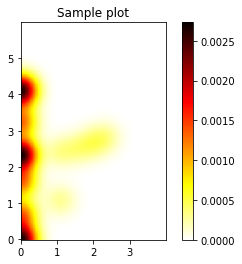

In [558]:
xlim = max_x//50+2
ylim = max_y//50+2
ana.heatmap(ents[:xlim*50, :ylim*50].transpose(1,0), sigma=15, cmap='hot_r')
plt.xticks(np.arange(0,xlim*50, 50), range(xlim))
plt.yticks(np.arange(0,ylim*50, 50), range(ylim))
plt.gca().invert_yaxis()
#plt.savefig('sample.jpg')
#plt.close()

## etc

In [104]:
args = main.get_args('')
ent = util.get_entropy(args, nZ=10)
ents = {k:[] for k in ent}

In [84]:
d_ents = copy.deepcopy(ents)
#uni_ents = copy.deepcopy(ents)

In [95]:
args['f'](9,nU-1)

37

In [120]:
for u in range(2, 11):
    nU = round(1.5**u)
    args = main.get_args(['--Y_fn', '%d*%dd%d' % (1, 8, 1), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [80]:
for nU in range(2, 20, 2):
    args = main.get_args(['--outcome_fn', 'd%d' % (nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [77]:
for u in range(2, 10):
    nU = round(1.5**u)
    args = main.get_args(['--noise', str(nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

Text(0,0.5,'HU')

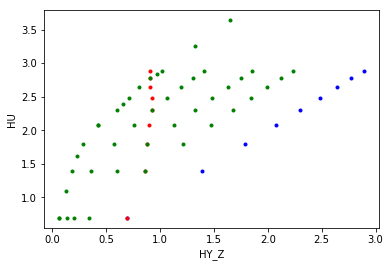

In [121]:
plt.plot(uni_ents['HY_Z'], uni_ents['HU'], 'b.')
plt.plot(d_ents['HY_Z'], d_ents['HU'], 'r.')
plt.plot(ents['HY_Z'], ents['HU'], 'g.')
plt.xlabel('HY_Z')
plt.ylabel('HU')
#plt.xlim(0,)

In [ ]:
for fn in glob.glob('history/*.ent'):
    hist_fns = glob.glob(fn[:-5]+"*.hist")
    if len(hist_fns) == 0:
        continue
    hist = io.pickle_load(hist_fns[0])
    acc = hist['val-acc'][-1]
    ent = io.pickle_load(fn)
    model_name = basename(hist_fns[0])[:-5]
    print(df.loc[model_name])
    df.loc[model_name, 'acc'] = acc
    desc = df.loc[model_name, 'model_type']
    ds = df.loc[model_name, 'dataset']
    xuy = np.load('data/%s/%s_val.npy' % (ds, desc))
    emp_post = util.emp_post(xuy)
    #true_post = util.true_post(xuy[:,:2], args['f'], noise=args['noise'])
    pred_post, pX, pU = util.pred_post(preds, xuy[:,:2])
    #true_KL = util.kl_div(pred_post, true_post, pX, pU)
    emp_KL = util.kl_div(pred_post, emp_post, pX, pU)
    #true_JS = util.js_div(pred_post, true_post, pX, pU)
    emp_JS = util.js_div(pred_post, emp_post, pX, pU)
    
    df.loc[model_name, 'true_KL'] = acc
    print(df.loc[model_name])
    break
    